# Libraries

In [ ]:
# Import the libraries needed

import pandas as pd
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import ResNet50, ResNet101
from keras.applications.resnet import preprocess_input
from keras.layers import concatenate, Dense, Dropout, Input, GlobalAveragePooling2D, Lambda
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Pre-processing of the metadata

## Inspect the metadata

Load and inspect the training, validation and test metadata

In [ ]:
train_df = pd.read_csv('/content/gdrive/My Drive/Master_thesis/ISIC-2017_Training_Data_metadata.csv')
val_df = pd.read_csv('/content/gdrive/My Drive/Master_thesis/ISIC-2017_Validation_Data_metadata.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/Master_thesis/ISIC-2017_Test_v2_Data_metadata.csv')

In [ ]:
train_df.head()

,image_id,age_approximate,sex
0,ISIC_0000000,55,female
1,ISIC_0000001,30,female
2,ISIC_0000002,60,female
3,ISIC_0000003,30,male
4,ISIC_0000004,80,male


In [ ]:
val_df.head()

,image_id,age_approximate,sex
0,ISIC_0001769,15,female
1,ISIC_0001852,10,female
2,ISIC_0001871,15,male
3,ISIC_0003462,15,female
4,ISIC_0003539,15,female


In [ ]:
test_df.head()

,image_id,age_approximate,sex
0,ISIC_0012086,30,male
1,ISIC_0012092,40,male
2,ISIC_0012095,25,male
3,ISIC_0012134,75,female
4,ISIC_0012136,70,male


Check the size, categories and missing values in each metadata

In [ ]:
# Size

print('Train data size:', len(train_df))
print('Validation data size:', len(val_df))
print('Test data size:', len(test_df))

Train data size: 2000
Validation data size: 150
Test data size: 600


In [ ]:
# Check the unique values - training

unique_values_age = train_df['age_approximate'].unique()
unique_values_sex = train_df['sex'].unique()
print(unique_values_sex)
print(unique_values_age)

['female' 'male' 'unknown']
['55' '30' '60' '80' '25' '35' '50' '45' '70' '40' '65' '20' '15' '85'
 'unknown' '5' '10' '75']


In [ ]:
# Check the unique values - validation

unique_values_age = val_df['age_approximate'].unique()
unique_values_sex = val_df['sex'].unique()
print(unique_values_sex)
print(unique_values_age)

['female' 'male' 'unknown']
['15' '10' '60' '35' '40' '25' '70' '55' '45' '65' '50' '30' '75' '85'
 '80' 'unknown' '20']


In [ ]:
# Check the unique values - test

unique_values_age = test_df['age_approximate'].unique()
unique_values_sex = test_df['sex'].unique()
print(unique_values_sex)
print(unique_values_age)

['male' 'female' 'unknown']
['30' '40' '25' '75' '70' '35' '10' '55' '50' '85' '45' '60' '65' '80'
 '15' 'unknown' '20']


In [ ]:
# Encode the missing values from "unknown" to "nan"

train_df.replace("unknown", np.nan, inplace=True)
val_df.replace("unknown", np.nan, inplace=True)
test_df.replace("unknown", np.nan, inplace=True)

In [ ]:
# Check the encoding

unique_values_age = train_df['age_approximate'].unique()
unique_values_sex = train_df['sex'].unique()
print(unique_values_sex)
print(unique_values_age)

['female' 'male' nan]
['55' '30' '60' '80' '25' '35' '50' '45' '70' '40' '65' '20' '15' '85' nan
 '5' '10' '75']


In [ ]:
# Training metadata

print('Number of categories in each column \n')
print(train_df.nunique())
print('------------------------------------\n')

missing_train = train_df.isnull().sum().sort_values(ascending = False)
percent_train = missing_train * 100 / len(train_df)
missing_percent_train  = pd.concat([missing_train, percent_train], axis = 1, keys = ['number', 'percent'])

print('Number and percentage of missing values in the columns \n')
print(missing_percent_train)
print('------------------------------------\n')

print('Percentage of observations in the categories of \'age_approximate\' \n')
print(train_df['age_approximate'].value_counts(ascending = True, normalize = True))
print('------------------------------------\n')

print('Percentage of observations in the categories of \'sex\' \n')
print(train_df['sex'].value_counts(ascending = True, normalize = True))

Number of categories in each column 

image_id           2000
age_approximate      17
sex                   2
dtype: int64
------------------------------------

Number and percentage of missing values in the columns 

                 number  percent
age_approximate     256    12.80
sex                 229    11.45
image_id              0     0.00
------------------------------------

Percentage of observations in the categories of 'age_approximate' 

age_approximate
5     0.002294
10    0.011468
20    0.022936
85    0.032683
80    0.045872
75    0.049885
25    0.055046
35    0.055619
70    0.072248
15    0.072821
30    0.073394
40    0.073968
55    0.075688
50    0.079128
65    0.080849
60    0.095183
45    0.100917
Name: proportion, dtype: float64
------------------------------------

Percentage of observations in the categories of 'sex' 

sex
female    0.491813
male      0.508187
Name: proportion, dtype: float64


In [ ]:
# Validation metadata

print('Number of categories in each column \n')
print(val_df.nunique())
print('------------------------------------\n')

missing_val = val_df.isnull().sum().sort_values(ascending = False)
percent_val = missing_val * 100 / len(val_df)
missing_percent_val  = pd.concat([missing_val, percent_val], axis = 1, keys = ['number', 'percent'])

print('Number and percentage of missing values in columns \n')
print(missing_percent_val)
print('------------------------------------\n')

print('Percentage of observations in the categories of \'age_approximate\' \n')
print(val_df['age_approximate'].value_counts(ascending = True, normalize = True))
print('------------------------------------\n')

print('Percentage of observations in the categories of \'sex\' \n')
print(val_df['sex'].value_counts(ascending = True, normalize = True))

Number of categories in each column 

image_id           150
age_approximate     16
sex                  2
dtype: int64
------------------------------------

Number and percentage of missing values in columns 

                 number   percent
age_approximate       1  0.666667
sex                   1  0.666667
image_id              0  0.000000
------------------------------------

Percentage of observations in the categories of 'age_approximate' 

age_approximate
20    0.006711
25    0.013423
30    0.020134
85    0.026846
80    0.033557
10    0.033557
45    0.053691
40    0.060403
35    0.060403
75    0.060403
65    0.080537
55    0.087248
70    0.100671
50    0.107383
60    0.114094
15    0.140940
Name: proportion, dtype: float64
------------------------------------

Percentage of observations in the categories of 'sex' 

sex
female    0.395973
male      0.604027
Name: proportion, dtype: float64


In [ ]:
# Test metadata

print('Number of categories in each column \n')
print(test_df.nunique())
print('------------------------------------\n')

missing_test = test_df.isnull().sum().sort_values(ascending = False)
percent_test = missing_test * 100 / len(test_df)
missing_percent_test  = pd.concat([missing_test, percent_test], axis = 1, keys = ['number', 'percent'])

print('Number and percentage of missing values in columns \n')
print(missing_percent_test)
print('------------------------------------\n')

print('Percentage of observations in the categories of \'age_approximate\' \n')
print(test_df['age_approximate'].value_counts(ascending=True, normalize=True))
print('------------------------------------\n')

print('Percentage of observations in the categories of \'sex\' \n')
print(test_df['sex'].value_counts(ascending = True, normalize = True))

Number of categories in each column 

image_id           600
age_approximate     16
sex                  2
dtype: int64
------------------------------------

Number and percentage of missing values in columns 

                 number   percent
age_approximate      47  7.833333
sex                  27  4.500000
image_id              0  0.000000
------------------------------------

Percentage of observations in the categories of 'age_approximate' 

age_approximate
10    0.007233
15    0.016275
20    0.016275
80    0.034358
85    0.041591
25    0.054250
55    0.061483
40    0.065099
30    0.066908
35    0.072333
75    0.083183
45    0.086799
65    0.088608
60    0.099458
50    0.099458
70    0.106691
Name: proportion, dtype: float64
------------------------------------

Percentage of observations in the categories of 'sex' 

sex
female    0.486911
male      0.513089
Name: proportion, dtype: float64


## Ground truth

Load and inspect the ground truth data, i.e. the labels

In [ ]:
train_truth = pd.read_csv('/content/gdrive/My Drive/Master_thesis/ISIC-2017_Training_Part3_GroundTruth.csv')
val_truth = pd.read_csv('/content/gdrive/My Drive/Master_thesis/ISIC-2017_Validation_Part3_GroundTruth.csv')
test_truth = pd.read_csv('/content/gdrive/My Drive/Master_thesis/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [ ]:
train_truth.head()

,image_id,melanoma
0,ISIC_0000000,0
1,ISIC_0000001,0
2,ISIC_0000002,1
3,ISIC_0000003,0
4,ISIC_0000004,1


In [ ]:
val_truth.head()

,image_id,melanoma
0,ISIC_0001769,0
1,ISIC_0001852,0
2,ISIC_0001871,0
3,ISIC_0003462,0
4,ISIC_0003539,0


In [ ]:
test_truth.head()

,image_id,melanoma
0,ISIC_0012086,0
1,ISIC_0012092,0
2,ISIC_0012095,0
3,ISIC_0012134,0
4,ISIC_0012136,0


In [ ]:
print('Number and percentage of observations in \'melanoma\' (class 1) and \'benign lesion\' (class 0) \n')

# Training set
counts_train = train_truth['melanoma'].value_counts(ascending=True)
percentages_train = train_truth['melanoma'].value_counts(ascending=True, normalize=True)

# Print in two-column format
print('Training set')
print(f"{'Class':<15}{'Number':<10}{'Percentage'}")
print('-' * 40)
for category, count in counts_train.items():
    print(f"{category:<15}{count:<10}{percentages_train[category]:.2%}")

print('------------------------------------\n')

# Validation set
counts_val = val_truth['melanoma'].value_counts(ascending=True)
percentages_val = val_truth['melanoma'].value_counts(ascending=True, normalize=True)

# Print in two-column format
print('Validation set')
print(f"{'Class':<15}{'Number':<10}{'Percentage'}")
print('-' * 40)
for category, count in counts_val.items():
    print(f"{category:<15}{count:<10}{percentages_val[category]:.2%}")

print('------------------------------------\n')

# Test set
counts_test = test_truth['melanoma'].value_counts(ascending=True)
percentages_test = test_truth['melanoma'].value_counts(ascending=True, normalize=True)

# Print in two-column format
print('Test set')
print(f"{'Class':<15}{'Number':<10}{'Percentage'}")
print('-' * 40)
for category, count in counts_test.items():
    print(f"{category:<15}{count:<10}{percentages_test[category]:.2%}")

Number and percentage of observations in 'melanoma' (class 1) and 'benign lesion' (class 0) 

Training set
Class          Number    Percentage
----------------------------------------
1              374       18.70%
0              1626      81.30%
------------------------------------

Validation set
Class          Number    Percentage
----------------------------------------
1              30        20.00%
0              120       80.00%
------------------------------------

Test set
Class          Number    Percentage
----------------------------------------
1              117       19.50%
0              483       80.50%


Melanoma and benign cases by sex and age

Sex

In [ ]:
# Melanoma cases by sex in the training set

malignant_df = train_truth[train_truth['melanoma'] == 1]
pd.crosstab(malignant_df['melanoma'], train_df['sex'])

sex,female,male
melanoma,,
1,118,197


In [ ]:
# Benign cases by sex in the training set

benign_df = train_truth[train_truth['melanoma'] == 0]
pd.crosstab(benign_df['melanoma'], train_df['sex'])

sex,female,male
melanoma,,
0,753,703


In [ ]:
# Melanoma cases by sex in the validation set

malignant_df_val = val_truth[val_truth['melanoma'] == 1]
pd.crosstab(malignant_df_val['melanoma'], val_df['sex'])

sex,female,male
melanoma,,
1,7,23


In [ ]:
# Benign cases by sex in the validation set

malignant_df_val = val_truth[val_truth['melanoma'] == 0]
pd.crosstab(malignant_df_val['melanoma'], val_df['sex'])

sex,female,male
melanoma,,
0,52,67


Age

In [ ]:
# Melanoma cases by age in the training set

malignant_df = train_truth[train_truth['melanoma'] == 1]
pd.crosstab(malignant_df['melanoma'], train_df['age_approximate'])

age_approximate,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85
melanoma,,,,,,,,,,,,,,,,
1,1,2,1,9,8,8,11,18,22,29,39,42,42,25,33,22


In [ ]:
# Benign cases by age in the training set

benign_df = train_truth[train_truth['melanoma'] == 0]
pd.crosstab(benign_df['melanoma'], train_df['age_approximate'])

age_approximate,10,15,20,25,30,35,40,45,5,50,55,60,65,70,75,80,85
melanoma,,,,,,,,,,,,,,,,,
0,19,125,39,87,120,89,118,158,4,116,103,127,99,84,62,47,35


In [ ]:
# Melanoma cases by age in the validation set

malignant_df_val = val_truth[val_truth['melanoma'] == 1]
pd.crosstab(malignant_df_val['melanoma'], val_df['age_approximate'])

age_approximate,35,40,45,50,55,60,65,70,75,80,85
melanoma,,,,,,,,,,,
1,1,2,1,1,4,3,5,7,1,3,2


In [ ]:
# Benign cases by age in the validation set

benign_df_val = val_truth[val_truth['melanoma'] == 0]
pd.crosstab(benign_df_val['melanoma'], val_df['age_approximate'])

age_approximate,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85
melanoma,,,,,,,,,,,,,,,,
0,5,21,1,2,3,8,7,7,15,9,14,7,8,8,2,2


## Imputation

Imputation in the training data

In [ ]:
# Merge the training metadata and ground truth on image_id
train_imputed = pd.merge(train_df, train_truth, on='image_id')

# Impute missing values in 'sex' based on 'melanoma'
train_imputed.loc[(train_imputed['sex'].isna()) & (train_imputed['melanoma'] == 1), 'sex'] = 'male'
train_imputed.loc[(train_imputed['sex'].isna()) & (train_imputed['melanoma'] == 0), 'sex'] = 'female'

# Impute missing values in 'age'
train_imputed.loc[(train_imputed['age_approximate'].isna()) & (train_imputed['melanoma'] == 1), 'age_approximate'] = '70'
train_imputed.loc[(train_imputed['age_approximate'].isna()) & (train_imputed['melanoma'] == 0), 'age_approximate'] = '45'

# Show the updated DataFrame
train_imputed.head()

,image_id,age_approximate,sex,melanoma
0,ISIC_0000000,55,female,0
1,ISIC_0000001,30,female,0
2,ISIC_0000002,60,female,1
3,ISIC_0000003,30,male,0
4,ISIC_0000004,80,male,1


In [ ]:
# Check for missing values

print(train_imputed.sex.isnull().sum())
print(train_imputed.age_approximate.isnull().sum())

0
0


Imputation in the validation data

In [ ]:
# Merge the train metadata and ground truth on image_id
val_imputed = pd.merge(val_df, val_truth, on='image_id')

# Impute missing values in 'sex' based on 'melanoma'
val_imputed.loc[(val_imputed['sex'].isna()) & (val_imputed['melanoma'] == 1), 'sex'] = 'male'
val_imputed.loc[(val_imputed['sex'].isna()) & (val_imputed['melanoma'] == 0), 'sex'] = 'female'

# Impute missing values in 'age'
val_imputed.loc[(val_imputed['age_approximate'].isna()) & (val_imputed['melanoma'] == 1), 'age_approximate'] = '70'
val_imputed.loc[(val_imputed['age_approximate'].isna()) & (val_imputed['melanoma'] == 0), 'age_approximate'] = '15'

# Show the updated DataFrame
val_imputed.head()

,image_id,age_approximate,sex,melanoma
0,ISIC_0001769,15,female,0
1,ISIC_0001852,10,female,0
2,ISIC_0001871,15,male,0
3,ISIC_0003462,15,female,0
4,ISIC_0003539,15,female,0


In [ ]:
# Check for missing values

print(val_imputed.sex.isnull().sum())
print(val_imputed.age_approximate.isnull().sum())

0
0


Imputation in the test data

In [ ]:
# Merge the train metadata and ground truth on image_id
test_imputed = pd.merge(test_df, test_truth, on='image_id')

# Impute missing values in 'age' and 'sex' with the mode
test_imputed['age_approximate'] = test_imputed['age_approximate'].fillna(test_imputed['age_approximate'].mode()[0])
test_imputed['sex'] = test_imputed['sex'].fillna(test_imputed['sex'].mode()[0])

# Check the updated new DataFrame
test_imputed.head()

,image_id,age_approximate,sex,melanoma
0,ISIC_0012086,30,male,0
1,ISIC_0012092,40,male,0
2,ISIC_0012095,25,male,0
3,ISIC_0012134,75,female,0
4,ISIC_0012136,70,male,0


In [ ]:
# Check for missing values

print(test_imputed.sex.isnull().sum())
print(test_imputed.age_approximate.isnull().sum())

0
0


Compare the unique categories in age in the 3 datasets

In [ ]:
print(train_imputed['age_approximate'].nunique())
print(val_imputed['age_approximate'].nunique())
print(test_imputed['age_approximate'].nunique())

17
16
16


In [ ]:
# Find the differences, i.e. find the categories in training, but not in validation and test

print(set(train_imputed['age_approximate'].unique()) - set(val_imputed['age_approximate'].unique()))
print(set(train_imputed['age_approximate'].unique()) - set(test_imputed['age_approximate'].unique()))

{'5'}
{'5'}


People aged 5 and 10 in the traininig data

In [ ]:
# Number of people aged 5 and 10 in the traininig data

age_5_count = (train_imputed['age_approximate'] == '5').sum()
age_10_count = (train_imputed['age_approximate'] == '10').sum()

print(f"People aged 5: {age_5_count}")
print(f"People aged 10: {age_10_count}")


People aged 5: 4
People aged 10: 20


In [ ]:
# Replace age 5 with age 10 in the training set

train_imputed['age_approximate'] = train_imputed['age_approximate'].replace('5', '10')

In [ ]:
# Number of people aged 10 in the traininig data

age_10_count = (train_imputed['age_approximate'] == '10').sum()
print(f"People aged 10: {age_10_count}")

People aged 10: 24


In [ ]:
train_imputed.head()

,image_id,age_approximate,sex,melanoma
0,ISIC_0000000,55,female,0
1,ISIC_0000001,30,female,0
2,ISIC_0000002,60,female,1
3,ISIC_0000003,30,male,0
4,ISIC_0000004,80,male,1


## One-hot encoding

Dummies (one-hot encoding) for sex and age in the training data

In [ ]:
train_finished = pd.get_dummies(train_imputed, columns=['sex', 'age_approximate'], prefix=['', ''])
train_finished.head()

,image_id,melanoma,_female,_male,_10,_15,_20,_25,_30,_35,_40,_45,_50,_55,_60,_65,_70,_75,_80,_85
0,ISIC_0000000,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,ISIC_0000001,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,ISIC_0000002,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,ISIC_0000003,0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,ISIC_0000004,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


Dummies (one-hot encoding) for sex and age in the validation data

In [ ]:
val_finished = pd.get_dummies(val_imputed, columns=['sex', 'age_approximate'], prefix=['', ''])
val_finished.head()

,image_id,melanoma,_female,_male,_10,_15,_20,_25,_30,_35,_40,_45,_50,_55,_60,_65,_70,_75,_80,_85
0,ISIC_0001769,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,ISIC_0001852,0,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,ISIC_0001871,0,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,ISIC_0003462,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,ISIC_0003539,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Dummies (one-hot encoding) for sex and age in the test data

In [ ]:
test_finished = pd.get_dummies(test_imputed, columns=['sex', 'age_approximate'], prefix=['', ''])
test_finished.head()

,image_id,melanoma,_female,_male,_10,_15,_20,_25,_30,_35,_40,_45,_50,_55,_60,_65,_70,_75,_80,_85
0,ISIC_0012086,0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,ISIC_0012092,0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,ISIC_0012095,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,ISIC_0012134,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,ISIC_0012136,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [ ]:
# Check data types

print(train_finished.dtypes)

image_id    object
melanoma     int64
_female       bool
_male         bool
_10           bool
_15           bool
_20           bool
_25           bool
_30           bool
_35           bool
_40           bool
_45           bool
_50           bool
_55           bool
_60           bool
_65           bool
_70           bool
_75           bool
_80           bool
_85           bool
dtype: object


# Add paths and .jpg to the images

Training data

In [ ]:
# Add the path and .jpg file extension to each image

train_finished['image_id'] = '/content/gdrive/My Drive/Master_thesis/ISIC-2017_Training_Data_cleaned/' + train_finished['image_id'] + '.jpg'

In [ ]:
# Check

train_finished.head()

,image_id,melanoma,_female,_male,_10,_15,_20,_25,_30,_35,_40,_45,_50,_55,_60,_65,_70,_75,_80,_85
0,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,/content/gdrive/My Drive/Master_thesis/ISIC-20...,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,/content/gdrive/My Drive/Master_thesis/ISIC-20...,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [ ]:
# Check the new image_id value of a particular image

train_finished['image_id'][1]

'/content/gdrive/My Drive/Master_thesis/ISIC-2017_Training_Data_cleaned/ISIC_0000001.jpg'

Validation data

In [ ]:
# Add the path and .jpg file extension to each image

val_finished['image_id'] = '/content/gdrive/My Drive/Master_thesis/ISIC-2017_Validation_Data_cleaned/' + val_finished['image_id'] + '.jpg'

In [ ]:
# Check

val_finished.head()

,image_id,melanoma,_female,_male,_10,_15,_20,_25,_30,_35,_40,_45,_50,_55,_60,_65,_70,_75,_80,_85
0,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Check the new image_id value of a particular image

val_finished['image_id'][1]

'/content/gdrive/My Drive/Master_thesis/ISIC-2017_Validation_Data_cleaned/ISIC_0001852.jpg'

Test data

In [ ]:
# Add the path and .jpg file extension to each image

test_finished['image_id'] = '/content/gdrive/My Drive/Master_thesis/ISIC-2017_Test_Data_cleaned/' + test_finished['image_id'] + '.jpg'

In [ ]:
# Check

test_finished.head()

,image_id,melanoma,_female,_male,_10,_15,_20,_25,_30,_35,_40,_45,_50,_55,_60,_65,_70,_75,_80,_85
0,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,/content/gdrive/My Drive/Master_thesis/ISIC-20...,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [ ]:
# Check the new image_id value of a particular image

test_finished['image_id'][1]

'/content/gdrive/My Drive/Master_thesis/ISIC-2017_Test_Data_cleaned/ISIC_0012092.jpg'

Save dataframes as csv files to Google Drive

In [ ]:
train_finished.to_csv('/content/gdrive/My Drive/Master_thesis/train_finished.csv', index=False)
val_finished.to_csv('/content/gdrive/My Drive/Master_thesis/val_finished.csv', index=False)
test_finished.to_csv('/content/gdrive/My Drive/Master_thesis/test_finished.csv', index=False)

# Inspect images

Example training image

In [ ]:
# Path to the training dataset directory
train_dir = '/content/gdrive/My Drive/Master_thesis/ISIC-2017_Training_Data_cleaned'

# Get a list of all .jpg files in the directory
image_files = [file for file in os.listdir(train_dir) if file.endswith('.jpg')]

# Randomly select an image file
random_image_file = random.choice(image_files)

# Construct the full path to the image
image_path = os.path.join(train_dir, random_image_file)

# Load the image
image = Image.open(image_path)

# Print the selected image name and details
print(f"Selected image: {random_image_file}")
print(f"The image dimensions are: {image.size} width x height")
print(f"The image mode is: {image.mode}")


Selected image: ISIC_0013071.jpg
The image dimensions are: (3872, 2592) width x height
The image mode is: RGB


Example validation image

In [ ]:
# Path to the validation dataset directory
val_dir = '/content/gdrive/My Drive/Master_thesis/ISIC-2017_Validation_Data_cleaned'

# Get a list of all .jpg files in the directory
image_files = [file for file in os.listdir(val_dir) if file.endswith('.jpg')]

# Randomly select an image file
random_image_file = random.choice(image_files)

# Construct the full path to the image
image_path = os.path.join(val_dir, random_image_file)

# Load the image
image = Image.open(image_path)

# Print the selected image name and details
print(f"Selected image: {random_image_file}")
print(f"The image dimensions are: {image.size} width x height")
print(f"The image mode is: {image.mode}")


Selected image: ISIC_0013632.jpg
The image dimensions are: (4288, 2848) width x height
The image mode is: RGB


Example test image

In [ ]:
# Path to the test dataset directory
test_dir = '/content/gdrive/My Drive/Master_thesis/ISIC-2017_Test_Data_cleaned'

# Get a list of all .jpg files in the directory
image_files = [file for file in os.listdir(test_dir) if file.endswith('.jpg')]

# Randomly select an image file
random_image_file = random.choice(image_files)

# Construct the full path to the image
image_path = os.path.join(test_dir, random_image_file)

# Load the image
image = Image.open(image_path)

# Print the selected image name and details
print(f"Selected image: {random_image_file}")
print(f"The image dimensions are: {image.size} width x height")
print(f"The image mode is: {image.mode}")


Selected image: ISIC_0015944.jpg
The image dimensions are: (3008, 2000) width x height
The image mode is: RGB


All images are of different size

Plot some training images

In [ ]:
IMAGE_SHAPE = (224, 224, 3) # width, height, channels

# Load images into a dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/gdrive/My Drive/Master_thesis/ISIC-2017_Training_Data_cleaned',
    labels=None,
    image_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),  # Resize all images to this size
    batch_size=32
)

Found 2000 files.


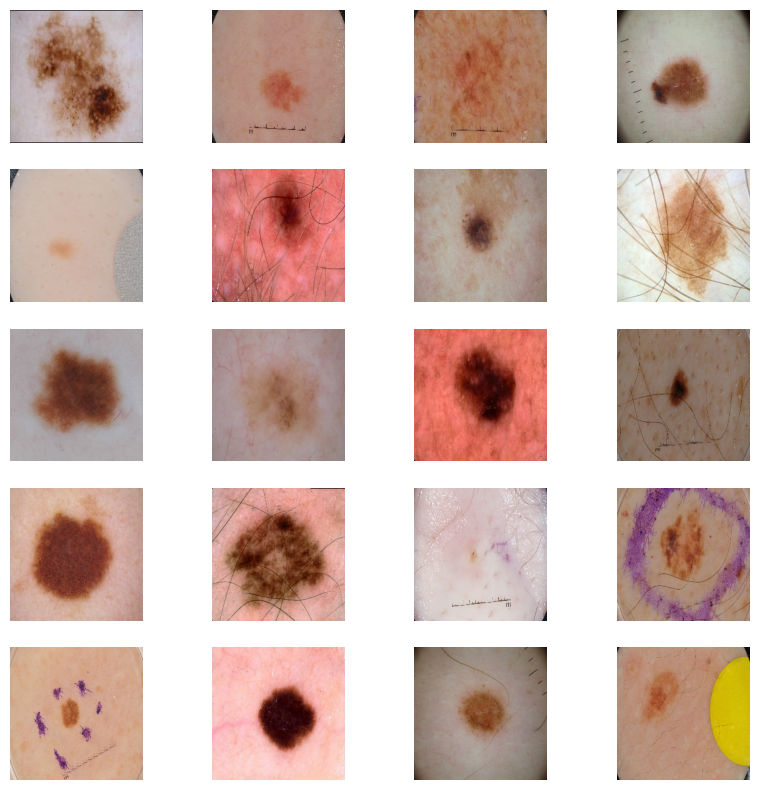

In [ ]:
# Display some images

import matplotlib.pyplot as plt
for images in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# Model

## Image branch - a pre-trained CNN and custom-defined FC layers

Create a function for the image branch

In [ ]:
IMAGE_SHAPE = (224, 224, 3) # width, height, channels

def cnn_net(name):

    if name == "ResNet50":
        model = ResNet50(weights = 'imagenet',
                         include_top = False,
                         input_shape = IMAGE_SHAPE)

        # Freeze all layers in the base model
        for layer in model.layers:
            layer.trainable = False

        # Unfreeze some layers by setting the 'trainable' attribute to True
        model.layers[-10].trainable = True



    if name == "ResNet101":
        model = ResNet101(weights = 'imagenet',
                          include_top = False,
                          input_shape = IMAGE_SHAPE)

    # Freeze all layers in the base model
        for layer in model.layers:
            layer.trainable = False

        # Unfreeze some layers by setting the 'trainable' attribute to True
        model.layers[-10].trainable = True



    # Apply preprocessing function to the input images
    x = Lambda(preprocess_input)(model.input)

    # Pass the preprocessed input through the ResNet model
    x = model(x)

    # Apply GlobalAveragePooling2D to the model output
    x = GlobalAveragePooling2D()(x)

    # Additional custom FC layers on top of the base model, i.e. the head
    # Note: This is just an example architecture. The number of layers and neurons changes depending on the model configuration.
    # See section Experiments for the exact architectures.

    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(32, activation = 'relu')(x)
    x = Dropout(0.3)(x)

    #x = Dense(16, activation = 'relu')(x)
    #x = Dropout(0.3)(x)

    #x = Dense(8, activation = 'relu')(x)
    #x = Dropout(0.3)(x)

    model = Model(model.input, x)


    return model

In [ ]:
# ResNet50 model

CNN_NET = cnn_net('ResNet50')
CNN_NET.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,155,488 (92.15 MB)

 Trainable params: 1,616,864 (6.17 MB)

 Non-trainable params: 22,538,624 (85.98 MB)

In [ ]:
# ResNet101 model

CNN_NET = cnn_net('ResNet101')
CNN_NET.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,225,952 (164.89 MB)

 Trainable params: 1,616,864 (6.17 MB)

 Non-trainable params: 41,609,088 (158.73 MB)

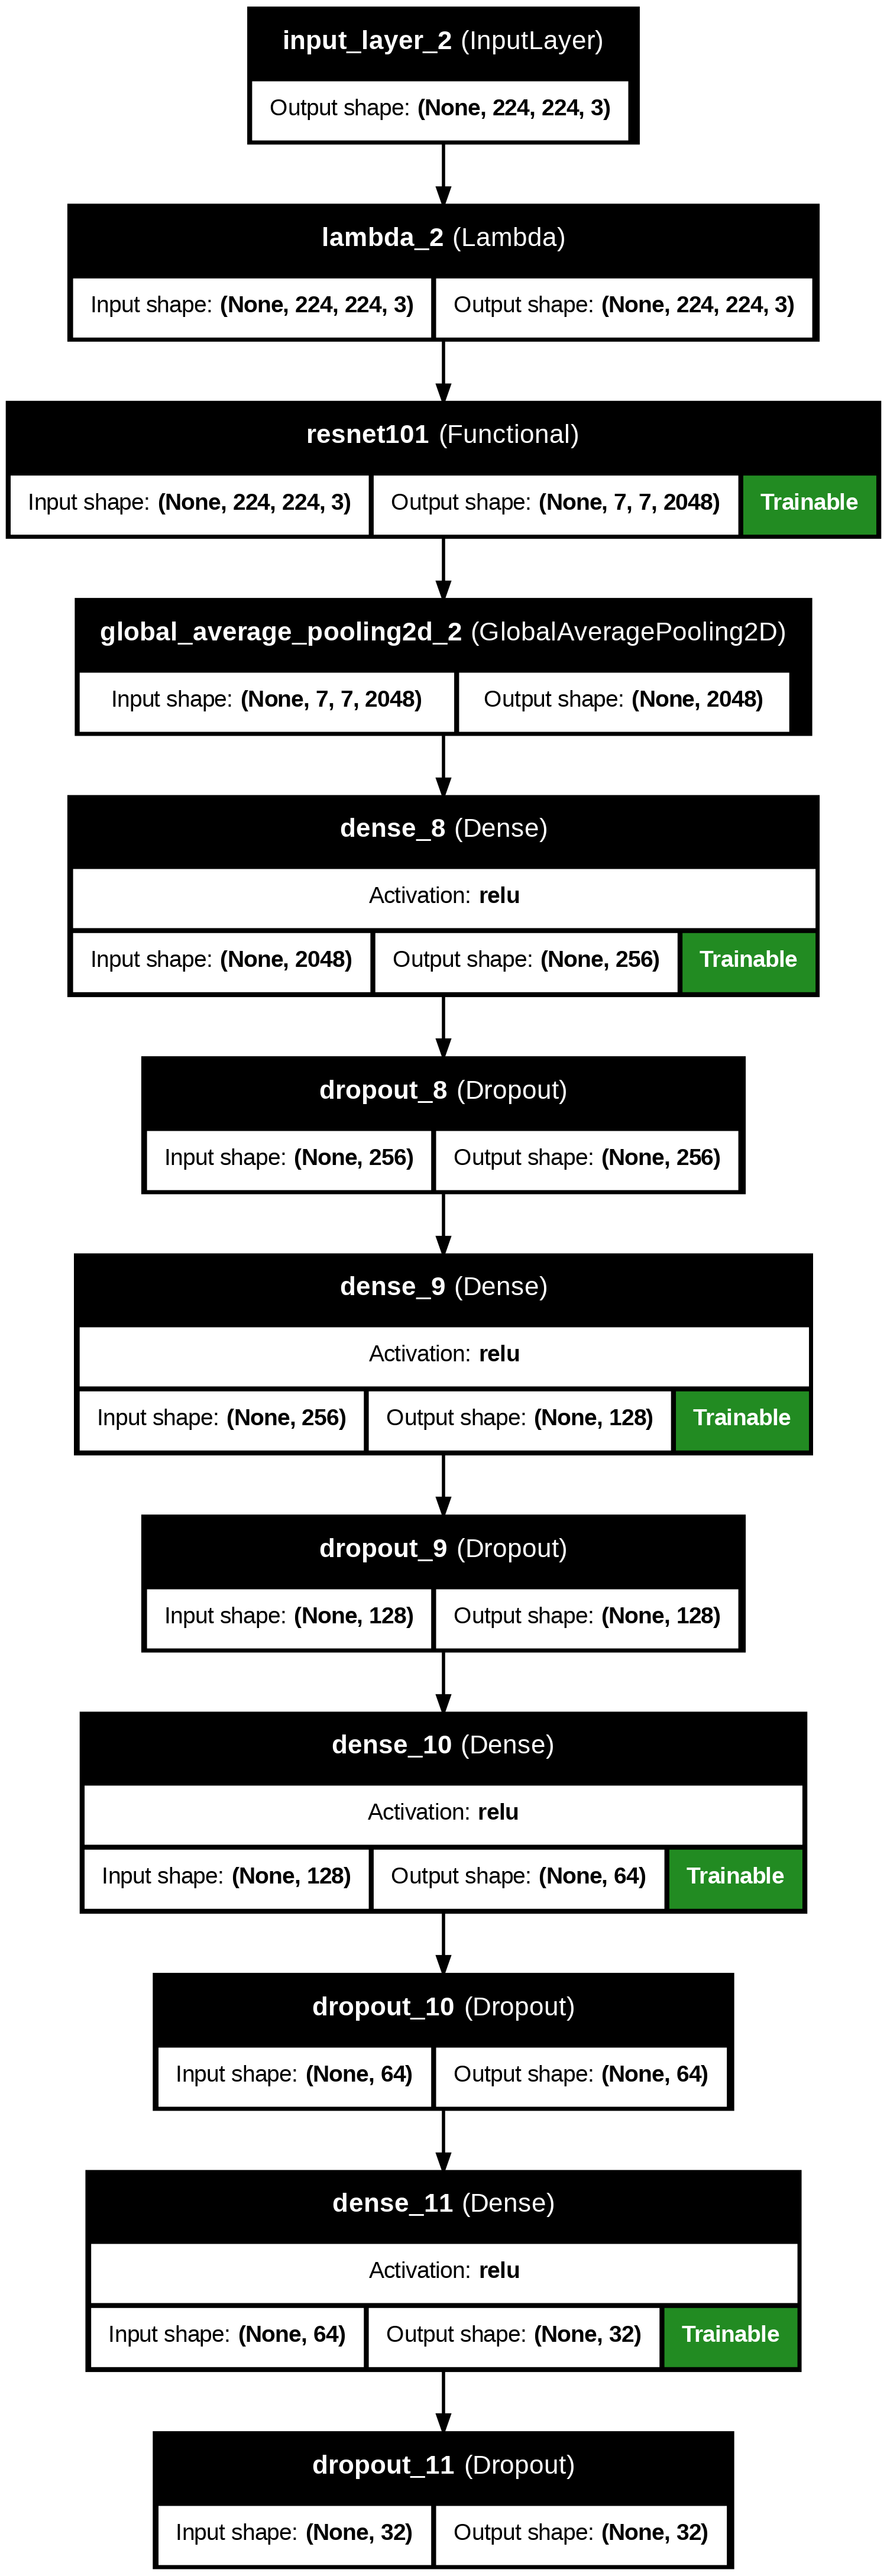

In [ ]:
plot_model(
    CNN_NET,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

## Metadata branch - simple FC ANN

In [ ]:
# Load the training metadata to get the metadata dimensions
train_finished = pd.read_csv('/content/gdrive/My Drive/Master_thesis/train_finished.csv')

# Exclude the first two columns and get the number of remaining columns
META_DIM = train_finished.iloc[:, 2:].shape[1]
print("Number of metadata columns:", META_DIM)

Number of metadata columns: 18


In [ ]:
def ann_net():

    # Define an input layer
    ann_input = Input(shape=(META_DIM,))


    # Build the model using the input layer
    # Note: This is just an example architecture. The number of layers and neurons changes depending on the model configuration.
    # See section Experiments for the exact architectures.

    x = Dense(256, activation="relu")(ann_input)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    #x = Dense(16, activation="relu")(x)
    #x = Dense(8, activation="relu")(x)

    # Create the model with the input and output
    model = Model(inputs=ann_input, outputs=x)

    return model


In [ ]:
ANN_NET = ann_net()
ANN_NET.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,096 (187.88 KB)

 Trainable params: 48,096 (187.88 KB)

 Non-trainable params: 0 (0.00 B)

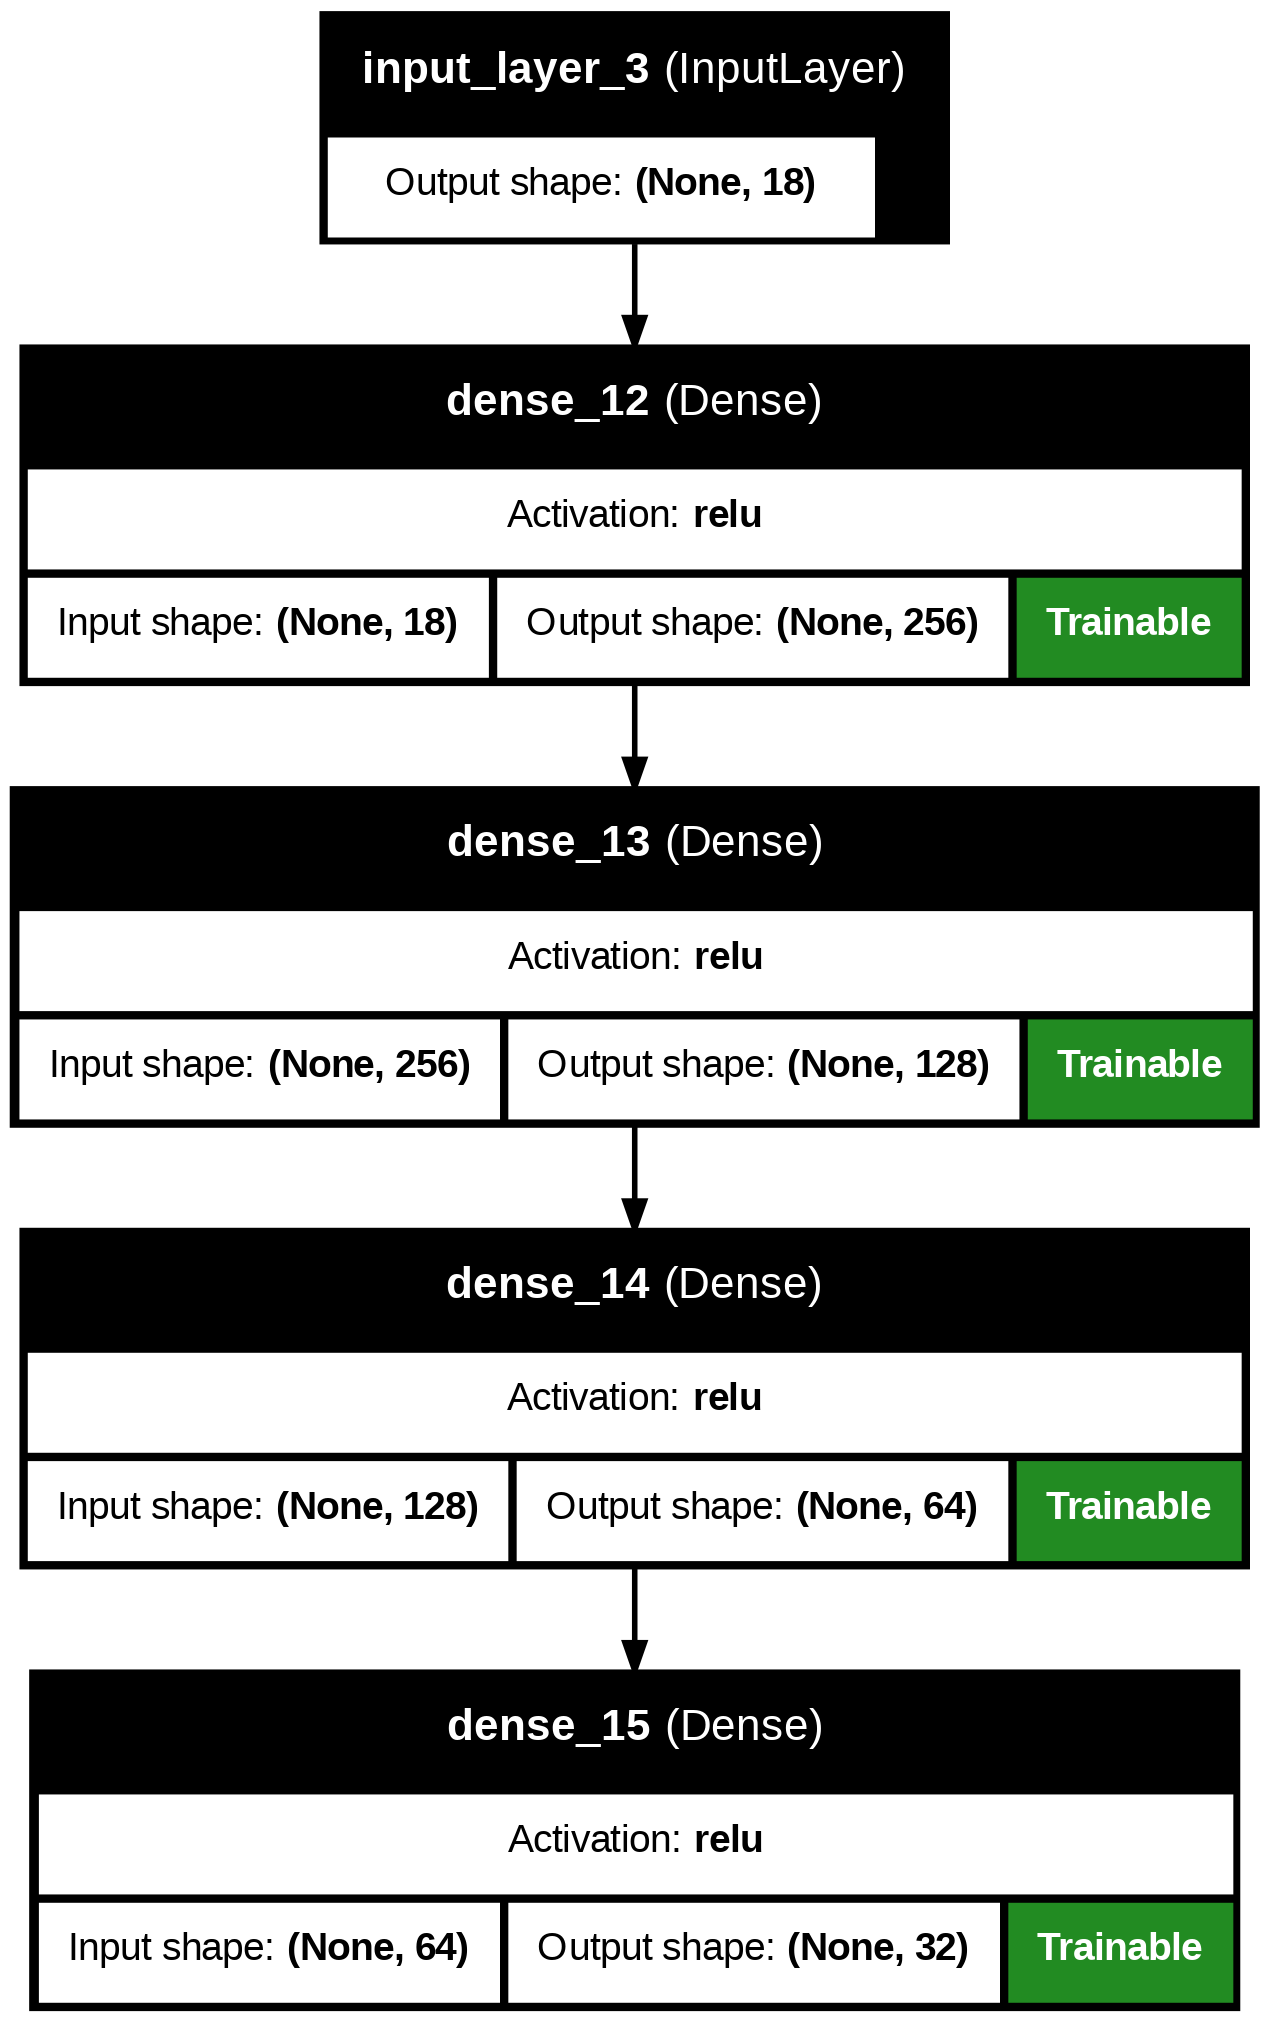

In [ ]:
# Plot the model

plot_model(
    ANN_NET,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

## Concatenated, i.e. combined, model

In [ ]:
def concatenated_net(cnn, mlp):

    combinedInput = concatenate([cnn.output, mlp.output])


    # Note: This is just an example architecture. The number of layers and neurons changes depending on the model configuration.
    # See section Experiments for the exact architctures.

    x = Dense(128, activation="relu")(combinedInput)
    x = Dropout(0.3)(x)

    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)

    x = Dense(32, activation="relu")(x)
    x = Dropout(0.5)(x)

    x = Dense(16, activation="relu")(x)
    x = Dropout(0.3)(x)

    #x = Dense(8, activation="relu")(x)
    #x = Dropout(0.3)(x)

    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs = [cnn.input, mlp.input], outputs = x)
    return model

In [ ]:
concatenated_model = concatenated_net(CNN_NET, ANN_NET)
concatenated_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 18)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │          4,864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │          2,080 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ dropout_3[0][0],       │
│                           │                        │                │ dense_7[0][0]          │
├──────────────────────

 Total params: 24,222,785 (92.40 MB)

 Trainable params: 1,684,161 (6.42 MB)

 Non-trainable params: 22,538,624 (85.98 MB)

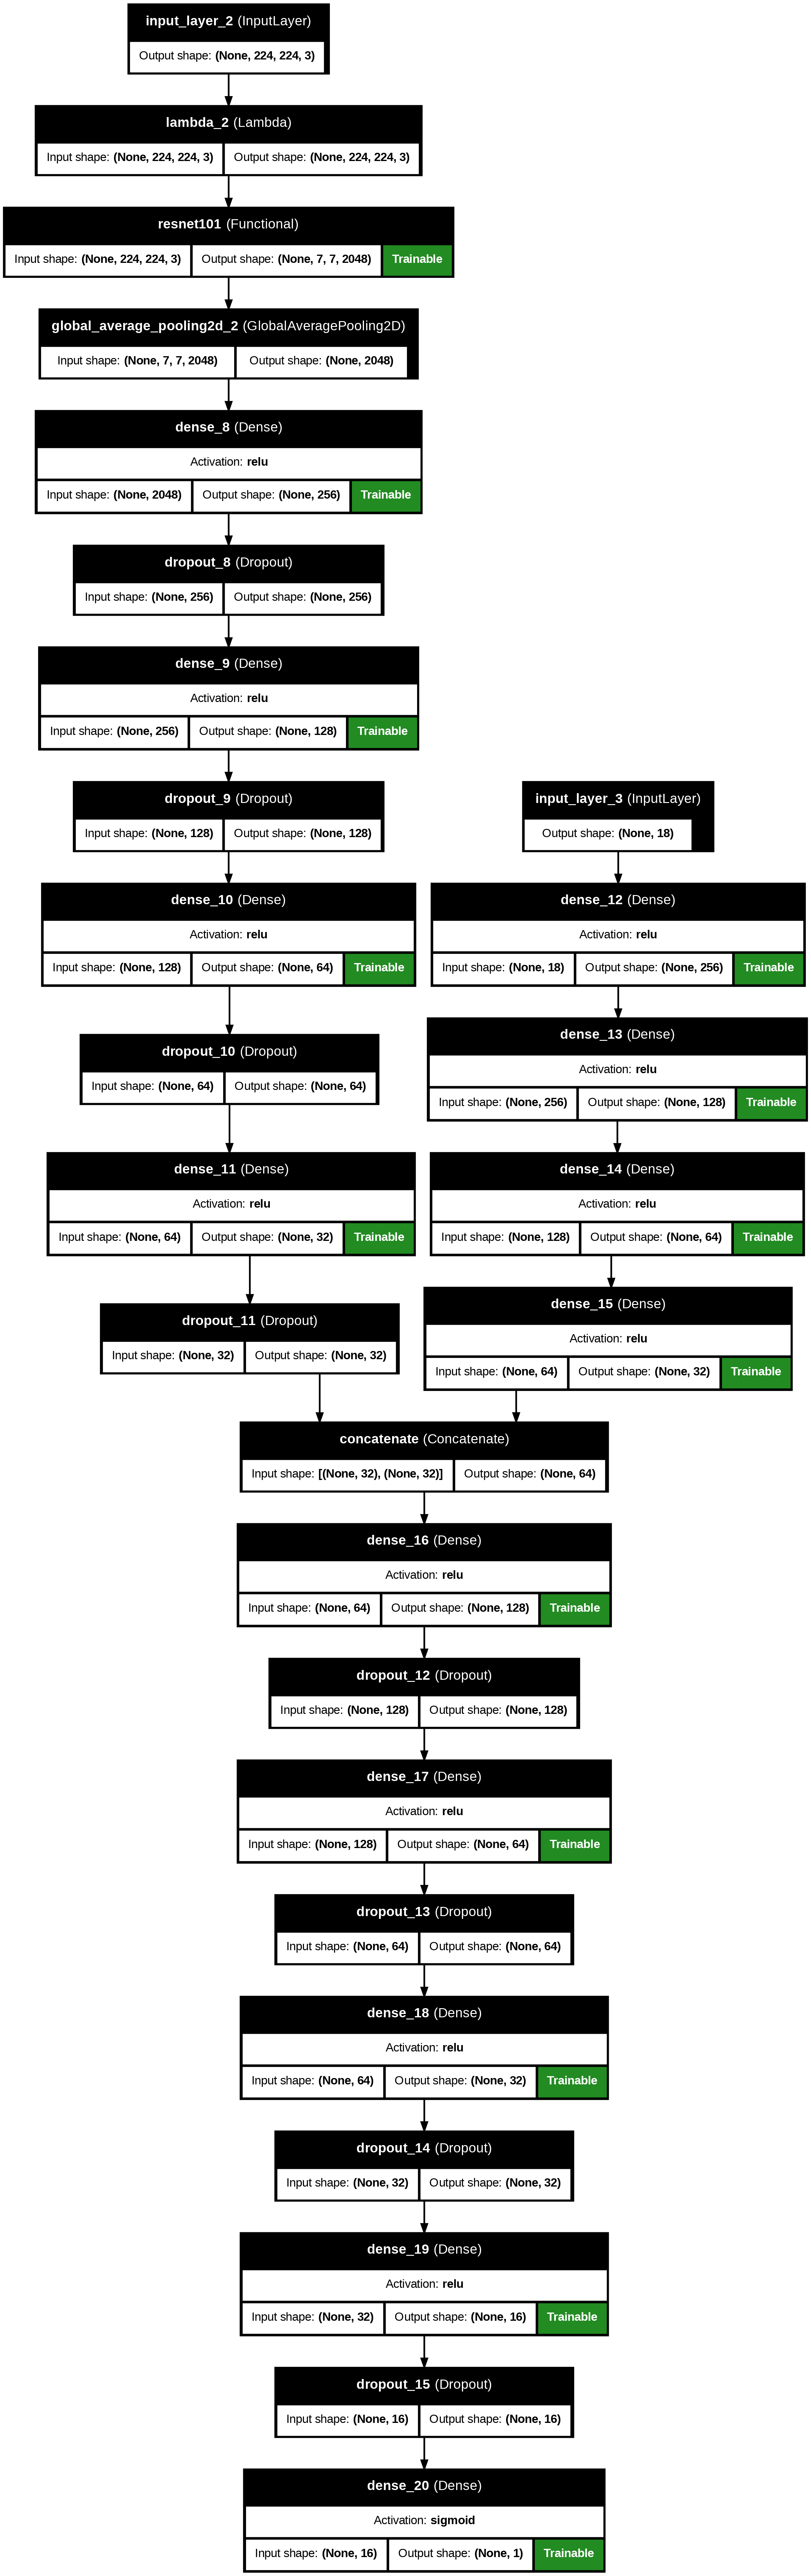

In [ ]:
# Plot the model

plot_model(
    concatenated_model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

# Prepare data for training

Load the finished datasets (imputed, one-hot encoded, with paths and .jpg file extension)

In [ ]:
train_finished = pd.read_csv('/content/gdrive/My Drive/Master_thesis/train_finished.csv')
val_finished = pd.read_csv('/content/gdrive/My Drive/Master_thesis/val_finished.csv')
test_finished = pd.read_csv('/content/gdrive/My Drive/Master_thesis/test_finished.csv')

Create an ImageDataGenerator for the training and validation datasets

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,         # Turn the image pixel values into numbers between 0 and 1.
    rotation_range = 150,       # Rotate the training images within the range [-150, 150] degrees.
    width_shift_range = 0.1,    # Shift the training images by up to 10% of their total width.
    height_shift_range = 0.1,   # Shift the training images by up to 10% of their total height.
    zoom_range = 0.3,           # Zoom in the training images between 0% (no zoom) and 30% of their original size.
    horizontal_flip = True,     # Randomly flip the training images horizontally.
    vertical_flip = True,       # Randomly flip the training images vertically.
    fill_mode = 'nearest',      # Fill the new pixels with the nearest pixel value from the original image
)

val_datagen = ImageDataGenerator(rescale = 1. / 255)  # Turn the image pixel values into numbers between 0 and 1.

Visualize the effect of data augmentation

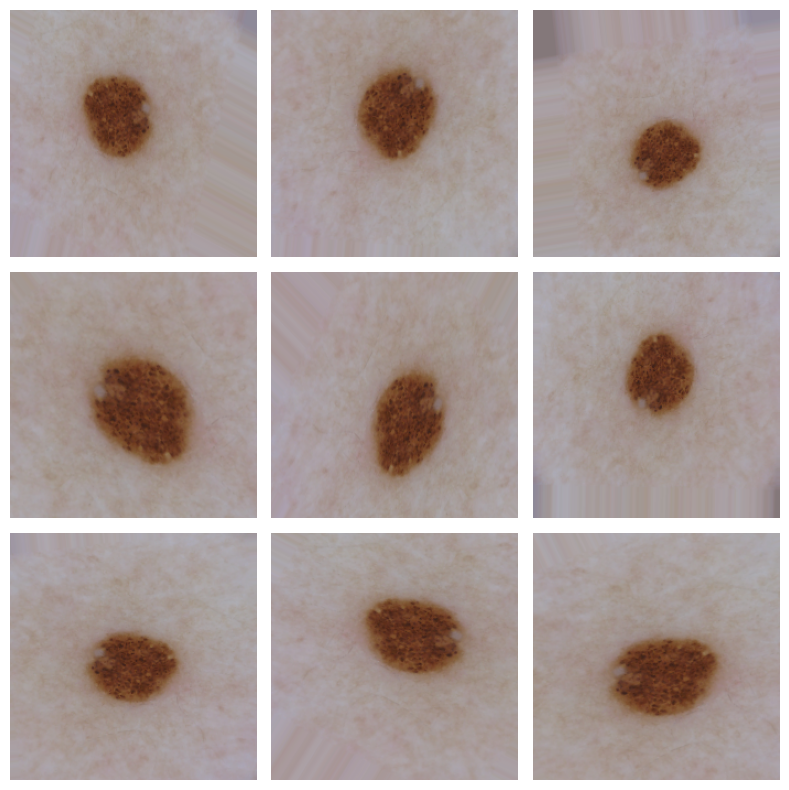

In [ ]:
# Path to the training dataset directory
train_dir = '/content/gdrive/My Drive/Master_thesis/ISIC-2017_Training_Data_cleaned'

# Get a list of all .jpg files in the directory
image_files = [file for file in os.listdir(train_dir) if file.endswith('.jpg')]

# Randomly select an image file
random_image_file = random.choice(image_files)

# Construct the full path to the image
image_path = os.path.join(train_dir, random_image_file)

# Load and preprocess the image
image = load_img(image_path, target_size=(224, 224))  # Resize to the target size
image_array = img_to_array(image)                     # Convert to NumPy array
image_array = np.expand_dims(image_array, axis=0)     # Add a batch dimension

# Generate augmented images
augmented_images = train_datagen.flow(image_array, batch_size=1)

# Determine figure size
plt.figure(figsize=(8, 8))

# Show 9 augmented images
for i in range(9):
    augmented_image = next(augmented_images)[0]
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.astype('uint8'))
    plt.axis('off')

plt.tight_layout()
plt.show()

Create data generators for the training and validation datasets

In [ ]:
IMAGE_SHAPE = (224, 224, 3) # width, height, channels
BATCH_SIZE = 50

train_generator = train_datagen.flow_from_dataframe(
    train_finished,
    x_col = 'image_id',
    y_col = train_finished.columns[1:],
    target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'raw',
    seed = 123)

validation_generator = val_datagen.flow_from_dataframe(
    val_finished,
    x_col = 'image_id',
    y_col = val_finished.columns[1:],
    target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    shuffle = True,
    batch_size = BATCH_SIZE,
    class_mode='raw',
    seed = 123)

Found 2000 validated image filenames.
Found 150 validated image filenames.


See the values of the images in one batch

In [ ]:
# The images

next(train_generator)[0]

array([[[[175.7184   , 166.7184   , 159.57472  ],
         [184.7134   , 175.7134   , 166.77072  ],
         [185.87083  , 173.38748  , 164.38748  ],
         ...,
         [181.16483  , 165.1099   , 142.27472  ],
         [183.92804  , 167.34242  , 146.09926  ],
         [185.32152  , 168.32152  , 148.77383  ]],

        [[170.75845  , 158.93076  , 150.87038  ],
         [180.46039  , 171.46039  , 163.3683   ],
         [185.44554  , 174.66339  , 165.66339  ],
         ...,
         [183.71146  , 167.16916  , 145.79604  ],
         [185.45148  , 168.45148  , 148.81715  ],
         [183.52982  , 166.52982  , 148.1766   ]],

        [[165.65483  , 150.42473  , 141.08844  ],
         [176.20737  , 167.20737  , 159.9659   ],
         [185.02023  , 175.93929  , 166.93929  ],
         ...,
         [185.58142  , 168.58142  , 148.86047  ],
         [183.65977  , 166.65977  , 148.21992  ],
         [183.84125  , 167.68251  , 149.26189  ]],

        ...,

        [[184.37198  , 169.4879   , 15

See the values of the metadata in a batch

In [ ]:
# The metadata - 18 columns

next(train_generator)[1][:,1:]

array([[False, True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, True],
       [True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, True, False],
       [True, False, False, False, False, False, False, False, False,
        False, False, True, False, False, False, False, False, False],
       [False, True, False, False, False, False, False, False, False,
        False, False, True, False, False, False, False, False, False],
       [False, True, False, False, False, False, False, False, False,
        False, False, False, False, False, True, False, False, False],
       [True, False, False, True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False],
       [True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False],
       [False

See the values of the labels in a batch

In [ ]:
# The label

next(train_generator)[1][:,0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=object)

Create custom data generators for the images, metadata and labels

In [ ]:
def own_train_generator_func():
    count = 0
    while True:
        if count == len(train_finished.index):
            train_generator.reset()
        count += 1
        data = next(train_generator)

        imgs = data[0]
        meta = data[1][:,1:]
        targets = data[1][:,0]

        # Reshape targets to (BATCH_SIZE, 1)
        targets = targets.reshape(-1, 1)

        yield (imgs, meta), targets

def own_validation_generator_func():
    count = 0
    while True:
        if count == len(val_finished.index):
            validation_generator.reset()
        count += 1
        data = next(validation_generator)

        imgs = data[0]
        meta = data[1][:,1:]
        targets = data[1][:,0]

        # Reshape targets to (BATCH_SIZE, 1)
        targets = targets.reshape(-1, 1)

        yield (imgs, meta), targets


Define the output signature based on the sample batch

In [ ]:
output_signature = (
    (
        tf.TensorSpec(shape=(BATCH_SIZE, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, META_DIM), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(BATCH_SIZE, 1), dtype=tf.float32)
)

output_signature

((TensorSpec(shape=(50, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(50, 18), dtype=tf.float32, name=None)),
 TensorSpec(shape=(50, 1), dtype=tf.float32, name=None))

Create datasets with the defined output_signature

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    own_train_generator_func,
    output_signature=output_signature
)

validation_dataset = tf.data.Dataset.from_generator(
    own_validation_generator_func,
    output_signature=output_signature
)

print(train_dataset)
print(validation_dataset)

<_FlatMapDataset element_spec=((TensorSpec(shape=(50, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(50, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(50, 1), dtype=tf.float32, name=None))>
<_FlatMapDataset element_spec=((TensorSpec(shape=(50, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(50, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(50, 1), dtype=tf.float32, name=None))>


# Compile the model

Create a focal loss function to handle class imbalance

In [ ]:
def focal_loss(alpha = 0.25, gamma = 2.0):    # Default values for alpha and gamma
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)

        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true * y_pred) + ((1-y_true) * (1-y_pred))

        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true * alpha + ((1-alpha) * (1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # Compute the final loss and return
        return K.mean(alpha_factor * modulating_factor * bce, axis = -1)

    return focal_crossentropy

Define evaluation metrics

In [ ]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name="accuracy"),  # TP + TN / total samples
    keras.metrics.Precision(name="precision"),      # TP / TP + FP
    keras.metrics.Recall(name="recall"),            # TP / TP + FN
    keras.metrics.AUC(name="auc", curve="ROC"),     # AUC means area under the curve. ROC means Receiver Operating Characteristic curve made by the true positive rate (TPR) and the false positive rate (FPR)
    keras.metrics.AUC(name='prc', curve='PR'),      # PR means Precision-Recall curve
    keras.metrics.F1Score(name='f1_score')          # 2 * (Precision * Recall) / (Precision + Recall), a balancing matrix between the precision and recall, the output range is [0, 1]
    ]

Compile the model

In [ ]:
concatenated_model.compile(optimizer = Adam(1e-05), # 1e−05 = 0.00001; Default value 1e-3 = 0.001
                           loss = focal_loss(), # instead of binary_crossentropy which is used for binary labels
                           metrics = METRICS
                           )

Determine the number of training and validation steps

In [ ]:
STEPS_PER_EPOCH = train_finished.shape[0] // BATCH_SIZE
VALIDATION_STEPS = val_finished.shape[0] // BATCH_SIZE

print("Number of training and validation steps, respectively: {} and {}".format(STEPS_PER_EPOCH, VALIDATION_STEPS))

Number of training and validation steps, respectively: 40 and 3


Create callbacks to save the best model based on validation loss

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = '/content/gdrive/My Drive/Master_thesis/Model_6.keras', # The file name to save the best model.
        monitor='val_loss',     # Monitor validation loss
        mode='min',             # Save the model when val_loss decreases
        save_best_only=True     # Saves the model only if the monitored metric improves.
    )
]

# Train the model

Train the model and store it in a history object

In [ ]:
history = concatenated_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS
)

# Train the model with class weights

An alternative to training the model without class weights

Find the number of melanoma and benign cases in the training set

In [ ]:
neg, pos = np.bincount(train_truth['melanoma'])
total = neg + pos
print(
    'Total: {}\n'
    'Melanoma: {} ({:.2f}% of total)\n'
    'Benign: {} ({:.2f}% of total)\n'.format(
        total,
        pos, 100 * pos / total,
        neg, 100 * neg / total
    )
)


Total: 2000
Melanoma: 374 (18.70% of total)
Benign: 1626 (81.30% of total)



Determine the class weights for melanoma and the benign cases

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_0 = (1 / neg) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 1 (melanoma): {:.2f}'.format(weight_for_1))
print('Weight for class 0 (benign): {:.2f}'.format(weight_for_0))


Weight for class 1 (melanoma): 2.67
Weight for class 0 (benign): 0.62


Train the model and store it in a history object

In [ ]:
weighted_history = concatenated_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    #callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weight   # The class weights go here
)

# Visualization and evaluation

Plot the training and validation loss and accuracy

In [ ]:
history_dict = history.history
# history_dict = weighted_history.history

# Extract loss and accuracy
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Figure size
plt.figure(figsize=(14, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plott training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Print the validation metrics

In [ ]:
def print_best_val_loss_and_accuracy(history):
    history_dict = history.history

    # Find the index of the best validation loss
    best_val_loss_index = np.argmin(history_dict['val_loss'])

    # Retrieve the best validation loss
    best_val_loss = history_dict['val_loss'][best_val_loss_index]

    # Retrieve the validation accuracy corresponding to the best validation loss
    best_val_accuracy = history_dict['val_accuracy'][best_val_loss_index]

    best_val_accuracy_all = max(history.history['val_accuracy'])

    # best tp
    best_tp_index = np.argmax(history_dict['val_tp'])
    best_tp = history_dict['val_tp'][best_tp_index]

    # best fp
    best_fp_index = np.argmin(history_dict['val_fp'])
    best_fp = history_dict['val_fp'][best_fp_index]

    # best tn
    best_tn_index = np.argmax(history_dict['val_tn'])
    best_tn = history_dict['val_tn'][best_tn_index]

    # best fn
    best_fn_index = np.argmin(history_dict['val_fn'])
    best_fn = history_dict['val_fn'][best_fn_index]

    # best precision
    best_precision_index = np.argmax(history_dict['val_precision'])
    best_precision = history_dict['val_precision'][best_precision_index]

    # best recall
    best_recall_index = np.argmax(history_dict['val_recall'])
    best_recall = history_dict['val_recall'][best_recall_index]

    # best auc
    best_auc_index = np.argmax(history_dict['val_auc'])
    best_auc = history_dict['val_auc'][best_auc_index]

        # best auc
    best_prc_index = np.argmax(history_dict['val_prc'])
    best_prc = history_dict['val_prc'][best_auc_index]

    # best f1
    best_f1_score_index = np.argmax(history_dict['val_f1_score'])
    best_f1_score = history_dict['val_f1_score'][best_f1_score_index]


    print(f"Best Validation Loss: {best_val_loss}")
    print(f"Validation Accuracy at Best Loss: {best_val_accuracy}")
    # Output the best metrics
    print(f"Validation Accuracy: {best_val_accuracy_all}")
    print(f"Best TruePositives: {best_tp}")
    print(f"Best FalsePositives: {best_fp}")
    print(f"Best TrueNegatives: {best_tn}")
    print(f"Best FalseNegatives: {best_fn}")
    print(f"Best Precision: {best_precision}")
    print(f"Best Recall: {best_recall}")
    print(f"Best AUC: {best_auc}")
    print(f"Best PRC: {best_prc}")
    print(f"Best F1 Score: {best_f1_score}")

In [ ]:
print_best_val_loss_and_accuracy(history)
# print_best_val_loss_and_accuracy(weighted_history)

# Test set

Create an ImageDataGenerator for the test set

In [ ]:
IMAGE_SHAPE = (224, 224, 3) # width, height, channels
BATCH_SIZE = 50

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    test_finished,
    x_col = 'image_id',
    y_col = test_finished.columns[1:],
    target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    shuffle = True,
    batch_size = BATCH_SIZE,
    class_mode='raw')

Found 600 validated image filenames.


Create a custom data generator for the images, metadata and labels

In [ ]:
def own_test_generator_func():
    count = 0
    while True:
        if count == len(test_finished.index):
            test_generator.reset()
            #break
        count += 1
        data = next(test_generator)

        imgs = data[0]
        meta = data[1][:,1:]
        targets = data[1][:,0]

        # Reshape targets to (BATCH_SIZE, 1)
        targets = targets.reshape(-1, 1)

        yield (imgs, meta), targets

Define the output signature based on the sample batch

In [ ]:
output_signature = (
    (
        tf.TensorSpec(shape=(BATCH_SIZE, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, META_DIM), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(BATCH_SIZE, 1), dtype=tf.float32)
)

output_signature

((TensorSpec(shape=(50, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(50, 18), dtype=tf.float32, name=None)),
 TensorSpec(shape=(50, 1), dtype=tf.float32, name=None))

Create a dataset with the defined output_signature

In [ ]:
test_dataset = tf.data.Dataset.from_generator(
    own_test_generator_func,
    output_signature=output_signature
)

test_dataset

<_FlatMapDataset element_spec=((TensorSpec(shape=(50, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(50, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(50, 1), dtype=tf.float32, name=None))>

Determine the number of test steps

In [ ]:
STEPS_TEST = test_finished.shape[0] // BATCH_SIZE

print("Number of test steps: {}".format(STEPS_TEST))

Number of training and validation steps: 12


Load the model

In [ ]:
custom_objects = {
    'preprocess_input': preprocess_input,
    'focal_crossentropy': focal_loss()
}

new_model = load_model('/content/gdrive/My Drive/Master_thesis/Model_3.keras', custom_objects=custom_objects)


See the model summary

In [ ]:
new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │         65,568 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            528 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 18)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │            608 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │            136 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 16)             │            528 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 8)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8)              │            136 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16)             │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 16)             │            272 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 8)              │            136 │ dropout_3[0][0]        │
├──────────────────────

 Total params: 25,889,653 (98.76 MB)

 Trainable params: 1,117,009 (4.26 MB)

 Non-trainable params: 22,538,624 (85.98 MB)

 Optimizer params: 2,234,020 (8.52 MB)

Make predictions for the test set

In [ ]:
results = new_model.evaluate(test_dataset, steps=STEPS_TEST)

See the evaluation metrics for the test set

In [ ]:
print("Loss: {:0.4f}".format(results[0]))
print("TP: {:0.4f}".format(results[1]))
print("FP: {:0.4f}".format(results[2]))
print("TN: {:0.4f}".format(results[3]))
print("FN: {:0.4f}".format(results[4]))
print("Acc: {:0.4f}".format(results[5]))
print("Precision: {:0.4f}".format(results[6]))
print("Recall: {:0.4f}".format(results[7]))
print("AUC: {:0.4f}".format(results[8]))
print("PRC: {:0.4f}".format(results[9]))
print("F1 score: {:0.4f}".format(results[10]))
